In [0]:
from __future__ import print_function, division

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()


# **Extracció de descriptors**

### Load Data

In [128]:
#!wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip" -O hymenoptera.zip                                  # Base de dades hymenoptera
!wget "https://github.com/gdsa-upc/2019-Equip1/blob/master/Sessi%C3%B3%203/tb_equip1.zip?raw=true" -O tb_2019.zip       # Les nostres imatges
#!wget "https://www.dropbox.com/s/si7jsz60mk767k8/tb_2018.zip?dl=0" -O tb_2018.zip                                      # Terrassa Buildins 2018


--2019-12-09 23:54:12--  https://github.com/gdsa-upc/2019-Equip1/blob/master/Sessi%C3%B3%203/tb_equip1.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gdsa-upc/2019-Equip1/raw/master/Sessi%C3%B3%203/tb_equip1.zip [following]
--2019-12-09 23:54:12--  https://github.com/gdsa-upc/2019-Equip1/raw/master/Sessi%C3%B3%203/tb_equip1.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gdsa-upc/2019-Equip1/master/Sessi%C3%B3%203/tb_equip1.zip [following]
--2019-12-09 23:54:13--  https://raw.githubusercontent.com/gdsa-upc/2019-Equip1/master/Sessi%C3%B3%203/tb_equip1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

In [0]:
#!unzip -qq hymenoptera.zip -d hymenoptera_data/      # Base de dades hymenoptera
!unzip -qq tb_2019.zip -d data/                       # Les nostres imatges
#!unzip -qq tb_2018.zip -d data_tb/                   # Terrassa Buildings 2018

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'hymenoptera_data/hymenoptera_data'     # Base de dades hymenoptera
data_dir = 'data'                                   # Les nostres imatges
#data_dir = 'data_tb'                               # Terrassa Buildings 2018

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Show images

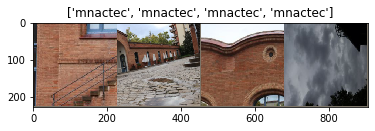

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualize predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Convnet as a fixed feature extractor

In [10]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)    #(In features , Out features)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv.fc

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 34.1MB/s]


Linear(in_features=2048, out_features=3, bias=True)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0935 Acc: 0.3947
val Loss: 1.4209 Acc: 0.3210

Epoch 1/24
----------
train Loss: 1.0826 Acc: 0.4474
val Loss: 0.9536 Acc: 0.4938

Epoch 2/24
----------
train Loss: 1.0151 Acc: 0.4868
val Loss: 0.8678 Acc: 0.6049

Epoch 3/24
----------
train Loss: 0.9301 Acc: 0.6053
val Loss: 0.7517 Acc: 0.7037

Epoch 4/24
----------
train Loss: 0.8440 Acc: 0.6711
val Loss: 0.5480 Acc: 0.7160

Epoch 5/24
----------
train Loss: 0.8334 Acc: 0.5526
val Loss: 0.7522 Acc: 0.5802

Epoch 6/24
----------
train Loss: 0.7272 Acc: 0.6053
val Loss: 0.5348 Acc: 0.7160

Epoch 7/24
----------
train Loss: 0.5736 Acc: 0.7632
val Loss: 0.4036 Acc: 0.8642

Epoch 8/24
----------
train Loss: 0.5159 Acc: 0.8026
val Loss: 0.3126 Acc: 0.9753

Epoch 9/24
----------
train Loss: 0.5302 Acc: 0.8289
val Loss: 0.3212 Acc: 0.9630

Epoch 10/24
----------
train Loss: 0.5226 Acc: 0.8026
val Loss: 0.3231 Acc: 0.9383

Epoch 11/24
----------
train Loss: 0.4733 Acc: 0.8553
val Loss: 0.3325 Acc: 0.9259

Ep

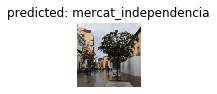

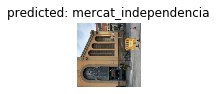

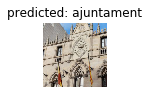

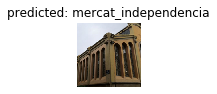

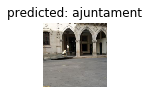

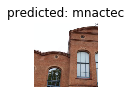

In [126]:
visualize_model(model_conv)

plt.ioff()
plt.show()